c:\Users\Monis\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0
BEFORE
AFTER
Train= 0
Train= 1
Train= 2
Train= 3
Train= 4
Train= 5
Train= 6
Train= 7
Train= 8
Train= 9
Train= 10
Train= 11
Train= 12
Train= 13
Train= 14
Train= 15
Train= 16
Train= 17
Train= 18
Train= 19
Train= 20
Train= 21
Train= 22
Train= 23
Train= 24
Train= 25
Train= 26
Train= 27
Train= 28
Train= 29
Train= 30
Train= 31
Train= 32
Train= 33
Train= 34
Train= 35
Train= 36
Train= 37
Train= 38
Train= 39
Train= 40
Train= 41
Train= 42
Train= 43
Train= 44
Train= 45
Train= 46
Train= 47
Train= 48
Train= 49
Train= 50
Train= 51
Train= 52
Train= 53
Train= 54
Train= 55
Train= 56
Train= 57
Train= 58
Train= 59
Train= 60
Train= 61
Train= 62
Train= 63
Train= 64
Train= 65
Train= 66
Train= 67
Train= 68
Train= 69
Train= 70
Train= 71
Train= 72
Train= 73
Train= 74
Train= 75
Train= 76
Train= 77
Train= 78
Train= 79
Train= 80
Train= 81
Train= 82
Train= 83
Train= 84
Train= 85
Train= 86
Train= 87
Train= 88
Train= 89
Train= 90
Train= 91
Train= 92
Train= 93
Train= 94
Train= 95
Train= 96
Train= 97
Train= 98


c:\Users\Monis\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   4]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 292]]


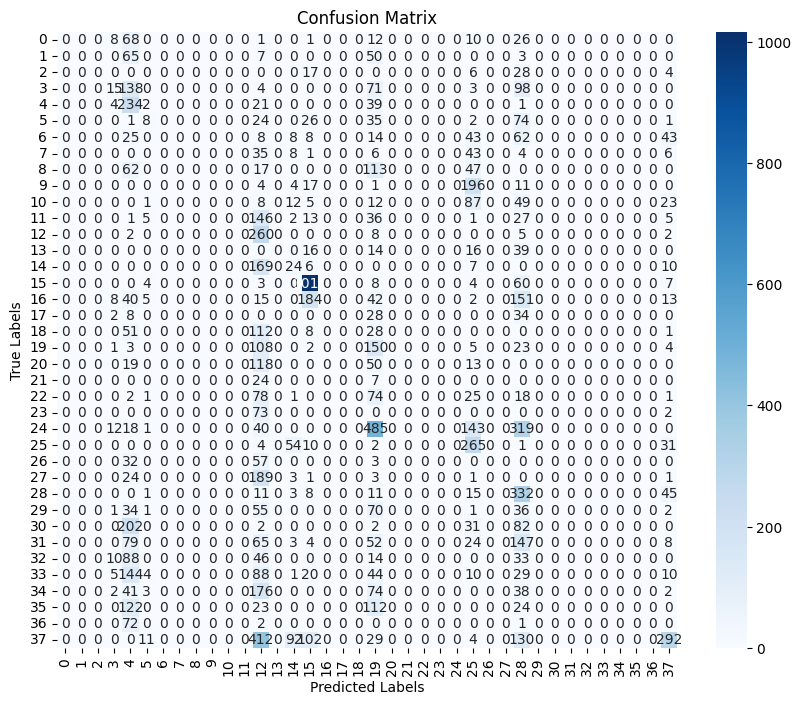

Accuracy: 0.2387
Precision: 0.0671
Recall: 0.1348
F1 Score: 0.0707
Average segment time: 0.0947 seconds
Number of misclassified images: 8280


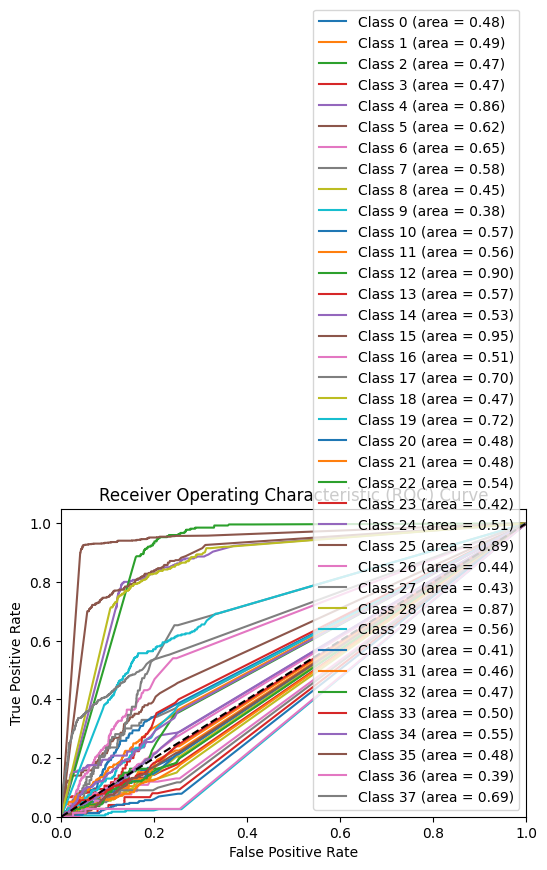

In [1]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import gc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch.multiprocessing as mp
import time

mp.set_start_method('spawn', force=True)

# Define the custom dataset path
dataset_path = './split1'

# Transformations for the data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Custom block to be added after DenseNet201
class CustomDenseBlock(nn.Module):
    def __init__(self, input_features, num_classes):
        super(CustomDenseBlock, self).__init__()
        # If the input is already pooled, we skip further pooling
        self.batch_norm = nn.BatchNorm1d(input_features)
        self.fc1 = nn.Linear(input_features, 256)
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Assume x is already a 2D tensor (batch_size, features)

        # Normalizing input to ensure consistency
        x = self.batch_norm(x)

        # Fully connected layers with ReLU and Dropout
        x = self.dropout1(nn.ReLU()(self.fc1(x)))
        x = self.dropout2(nn.ReLU()(self.fc2(x)))
        x = self.dropout3(nn.ReLU()(self.fc3(x)))
        x = self.fc4(x)
        return x

    

# Load pretrained DenseNet-201 model and modify the classifier
densenet201 = torchvision.models.densenet201(pretrained=True)
input_features = densenet201.classifier.in_features
densenet201.classifier = nn.Identity() 

# Create the final model combining DenseNet201 and the custom dense block
class CustomModel(nn.Module):
    def __init__(self, base_model, input_features, num_classes):
        super(CustomModel, self).__init__()
        self.base_model = base_model  # The transfer learning base model
        self.custom_block = CustomDenseBlock(input_features, num_classes)

    def forward(self, x):

        features = self.base_model(x)

        # Pass the 2D tensor through the custom dense block
        out = self.custom_block(features)

        return out
# Instantiate the custom model
model = CustomModel(densenet201,input_features, num_classes=38)
model.to(device)


import os
import numpy as np

def preprocess_image(image):
    try:
        # Convert image from PIL to OpenCV format (BGR)
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Convert BGR to Lab
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        # Split the LAB image into its channels
        l_channel, a_channel, b_channel = cv2.split(lab_image)
        
        # Apply CLAHE to L-channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_channel = clahe.apply(l_channel)
        
        # Merge the channels back
        lab_image = cv2.merge((l_channel, a_channel, b_channel))
        
        # Convert Lab back to BGR
        bgr_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
        
        # Apply Adaptive Median Filter (Optional)
        bgr_image = cv2.medianBlur(bgr_image, ksize=3)
        
        # Apply Gamma Correction (Optional)
        gamma = 1.2
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        bgr_image = cv2.LUT(bgr_image, table)
        
        # Convert back to PIL format and then to tensor
        image = Image.fromarray(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB))
        
        # Convert image to numpy array and normalize to -1 to +1
        image = np.array(image).astype(np.float32)
        image = (image / 127.5) - 1.0
        
        # Ensure the output shape is correct
        if image.shape != (256, 256, 3):
            raise ValueError(f"Image shape is {image.shape}, expected (256, 256, 3)")
        
        # Convert to tensor
        image = torch.from_numpy(image).permute(2, 0, 1)  # Shape: (3, 256, 256)
        
        return image
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None

# Modify CustomDataset to include error handling
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.images = []
        self.labels = []

        for label, class_dir in enumerate(os.listdir(image_folder)):
            class_path = os.path.join(image_folder, class_dir)
            for img_file in os.listdir(class_path):
                self.images.append(os.path.join(class_path, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        image = preprocess_image(image)
        if image is None:
            raise ValueError(f"Failed to preprocess image at index {idx}")
        label = self.labels[idx]
        return image, label


# Load custom dataset
trainset = CustomDataset(dataset_path + '/Train')
#testset = ImageFolder(root=dataset_path + '/Test',transform=transform)
testset = CustomDataset(dataset_path + '/Test')


# Define the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
train_labels = [label for _, label in trainset]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Training the model
def train_model(model, trainloader, criterion, optimizer, scaler, epochs=1):
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        model.train()
        print("BEFORE")
        print(enumerate(testloader))
        print("AFTER")
        for i, data in enumerate(trainloader):
            print("Train=",i)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch + 1} completed in {epoch_time:.2f} seconds')
    
    print('Finished Training')

# Calculate IoU for each class
def calculate_iou(confusion_matrix):
    iou_per_class = {}
    for idx, label in enumerate(trainset.classes):
        true_positives = confusion_matrix[idx, idx]
        false_positives = confusion_matrix[:, idx].sum() - true_positives
        false_negatives = confusion_matrix[idx, :].sum() - true_positives
        iou = true_positives / (true_positives + false_positives + false_negatives)
        iou_per_class[label] = iou
    return iou_per_class

# Evaluate the model
def evaluate_model(model, testloader):
    model.eval()
    all_labels = []
    all_predictions = []
    y_pred_prob = np.zeros((len(testloader.dataset),38))
    total_time = 0
    misclassified_count = 0
    with torch.no_grad():
        print("TEST")
        for i, data in enumerate(testloader):
            print("TEST=",i)
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            segment_time = time.time() - start_time
            total_time += segment_time
            
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            y_pred_prob[i*testloader.batch_size:i*testloader.batch_size + outputs.size(0), :] = torch.softmax(outputs, dim=1).cpu().numpy()

            # Count misclassified images
            misclassified_count += (predicted != labels).sum().item()
    
    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

     # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Print additional metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average segment time: {total_time / len(testloader):.4f} seconds")

    # Print the number of misclassified images
    print(f"Number of misclassified images: {misclassified_count}")

    
    
    # ROC Curve
    y_true_bin = label_binarize(all_labels, classes=range(38))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(38):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(6, 4))
    for i in range(38):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Train and evaluate
train_model(model, trainloader, criterion, optimizer, scaler, epochs=2)
evaluate_model(model, testloader)

# Free GPU memory
torch.cuda.empty_cache()

# Explicitly delete model and other tensors on the GPU
del model
del trainloader
del testloader
del criterion
del optimizer
del scaler

# Force a garbage collection to clean up any remaining objects
gc.collect()

# Final GPU memory cleanup
torch.cuda.empty_cache()

